In [1141]:
import time
import copy
import sys
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [1142]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
import numpy as np

In [1143]:
# Using CIFAR-10 again as in Assignment 1
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# data_dir = '/home/jovyan/harvard-heavy/xin/cifar10_data/'
data_dir = '/n/holyscratch01/kung_lab/xin/cifar_data'
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                         num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [1144]:
# Using same ConvNet as in Assignment 1
'''
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)
'''

class ConvNet(nn.Module):
    '''
    From https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [1145]:
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

In [1146]:
## for test
# test_corr = DatasetSplit(testset, [1,2,3])
# len(test_corr)

In [1147]:
def train(epoch, device):
    net.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.cuda(), targets.cuda()
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        
        if isinstance(device['criterion'], nn.CrossEntropyLoss):
            loss = device['criterion'](outputs, targets)
        else:
            loss, data_loss, fisher_loss = device['criterion'](outputs, targets, False)
            device['train_data_loss_tracker'].append(data_loss.item())
            device['train_fisher_loss_tracker'].append(fisher_loss.item())
            
        loss.backward()
        # nn.utils.clip_grad_norm_(device['net'].parameters(), max_norm = 1)
        nn.utils.clip_grad_value_(device['net'].parameters(), clip_value=5)
        
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        avg_loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        
    print('\n'+' '*30)
    if isinstance(device['criterion'], nn.CrossEntropyLoss):
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {avg_loss:.3f} | Train Acc: {acc:.3f}')
    else:
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {avg_loss:.3f} Data: {data_loss.item():.3f} Fisher: {fisher_loss.item():.6f} | Train Acc: {acc:.3f}')
    sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device):
    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = device['net'](inputs)
            
            if isinstance(device['criterion'], nn.CrossEntropyLoss):
                loss = device['criterion'](outputs, targets)
            else:
                loss, data_loss, fisher_loss = device['criterion'](outputs, targets, False)
            
            test_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            avg_loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
            
    device['test_loss_tracker'].append(avg_loss)

    if isinstance(device['criterion'], nn.CrossEntropyLoss):
        sys.stdout.write(f' | Test Loss: {avg_loss:.3f} | Test Acc: {acc:.3f}\n')
    else:
        sys.stdout.write(f' | Test Loss: {avg_loss:.3f}, Data: {data_loss.item():.8f}, Reg: {fisher_loss.item():.8f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)
    return acc

In [1148]:
def create_device(net, device_id, trainset, data_idxs, criterion, lr=0.01,
                  milestones=None, batch_size=32):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9,
                                weight_decay=5e-4)
#     optimizer = torch.optim.Adam(device_net.parameters(), lr=lr,
#                                 weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     num_workers=2)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'criterion': criterion,
        'train_loss_tracker': [],
        'train_data_loss_tracker': [],
        'train_fisher_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_data_loss_tracker': [],
        'test_fisher_loss_tracker': [],
        'test_acc_tracker': [],
        }
    
def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentage of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''

    # total number of samples in the dataset
    total_samples = len(dataset)

    # Part 1.1: Implement!
    device_samples = round(data_pct * total_samples)
    return {i: torch.randperm(total_samples)[:device_samples].tolist() 
            for i in range(num_devices)}

def noniid_sampler(dataset, num_users, num_shards_per_user=2):
    """
    Sample non-I.I.D client data from dataset
    """
    total_num_imgs = len(dataset)
    num_shards = int(num_shards_per_user*num_users)
    num_imgs = int(total_num_imgs/num_shards)

    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = np.array(dataset.targets)

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    # idxs_labels[1, :].argsort(): sort idxs by classes
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()].astype(int)
    # idxs_labels:
    # array([[30207,  5662, 55366, ..., 23285, 15728, 11924],
    #        [    0,     0,     0, ...,     9,     9,     9]])
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, num_shards_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0).astype(int)
    return dict_users


In [1149]:
def fisher_matrix_diag(device, batch_size=None, empr=False):
    # Init
    model = device['net']
    batch_size = len(device['dataloader'].dataset) if batch_size is None else batch_size
    dataloader =  torch.utils.data.DataLoader(device['dataloader'].dataset,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     num_workers=0)
    fisher={}
    for n,p in model.named_parameters():
        fisher[n]=torch.zeros_like(p.data).detach()
    # Compute
    model.eval()
    total_num_samples = 0
    for image, target in dataloader:
        image, target = image.cuda(), target.cuda()
        total_num_samples += image.size(0)
        # Forward and backward
        model.zero_grad()
        output=model.forward(image)
        if empr:
            target = output.max(1)[1]
        loss=criterion(output, target)
        loss.backward()
        # Get gradients
        for n,p in model.named_parameters():
            if p.grad is not None:
                fisher[n] += image.size(0) * (p.grad.detach() ** 2)
                
    for n in fisher.keys():
        fisher[n] /= total_num_samples
        fisher[n].requires_grad=False
    return fisher


def mas_matrix(device, batch_size=None):
    # Init
    model = device['net']
    # batch_size = len(device['dataloader'].dataset) if batch_size is None else batch_size
    assert batch_size is not None
    
    dataloader =  torch.utils.data.DataLoader(device['dataloader'].dataset,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     num_workers=0)
    fisher={}
    for n,p in model.named_parameters():
        fisher[n]=torch.zeros_like(p.data).detach()
    # Compute
    model.eval()
    total_num_samples = 0
    
    target = None
    loss_func = torch.nn.MSELoss(reduction='sum')
    
    for idx, (image, _) in enumerate(dataloader):
        image = image.cuda()
        total_num_samples += image.size(0)
        assert image.size(0) == batch_size
        # Forward and backward
        model.zero_grad()
        output=model.forward(image)

        if target is None:
            target = torch.zeros_like(output, requires_grad=False)
        
        loss=loss_func(output, target)
        loss.backward()
        # Get gradients
        for n,p in model.named_parameters():
            if p.grad is not None:
                fisher[n] = fisher[n].mul(idx*batch_size) 
                fisher[n] = fisher[n].add(p.grad.data.clone().abs_())
                fisher[n] = fisher[n].div((idx+1)*batch_size)
                
    return fisher


'''
def update_fisher_params(self, current_ds, batch_size, num_batch=None):
    dl = DataLoader(current_ds, batch_size, shuffle=True)
    log_liklihoods = []
    for i, (input, target) in enumerate(dl):
        if num_batch is not None:
            if i > num_batch:
                break
        output = F.log_softmax(self.model(input), dim=1)
        log_liklihoods.append(output[:, target])
    log_likelihood = torch.cat(log_liklihoods).mean()
    grad_log_liklihood = autograd.grad(log_likelihood, self.model.parameters())
    _buff_param_names = [param[0].replace('.', '__') for param in self.model.named_parameters()]
    for _buff_param_name, param in zip(_buff_param_names, grad_log_liklihood):
        self.model.register_buffer(_buff_param_name+'_estimated_fisher', param.data.clone() ** 2)
'''       

def get_fisher_criterion(criterion, fisher, model, model_old, lamb):
    # Regularization for all previous tasks
    def fisher_criterion(output, target, ifprint=True):
        loss_reg=0
        for (name,param),(name_old,param_old) in zip(model.named_parameters(), model_old.named_parameters()):
            assert name==name_old
            loss_reg+=torch.sum(fisher[name].detach()*((param_old.detach()-param)**2))
            
        data_loss = criterion(output, target)
        
        if ifprint:
            print('\n N: %f, R: %f' % (data_loss.item(), lamb*loss_reg.item()))

        return data_loss + lamb*loss_reg, data_loss, lamb*loss_reg

    return fisher_criterion


def get_l2_criterion(criterion, model, model_old, lamb):
    # Regularization for all previous tasks
    def l2_criterion(output, target, ifprint=True):
        loss_reg=0
        for (name,param),(name_old,param_old) in zip(model.named_parameters(), model_old.named_parameters()):
            assert name==name_old
            loss_reg+=torch.sum((param_old.detach()-param)**2)
            
        data_loss = criterion(output, target)
            
        if ifprint:
            print('\n N: %f, R: %f' % (data_loss.item(), lamb*loss_reg.item()))

        return data_loss + lamb*loss_reg, data_loss, lamb*loss_reg

    return l2_criterion

In [1150]:
def average_weights(devices):
    '''
    Returns the average of the weights.
    '''
    # Part 1.2: Implement!
    w = [device['net'].state_dict() for device in devices]
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
        
    return w_avg


def zeros_like_copy(in_state_dict):
    out_state_dict = {}
    for key in in_state_dict.keys():
        out_state_dict[key] = torch.zeros_like(in_state_dict[key])
    return out_state_dict
    

def fisher_average_weights(devices):
    w = [device['net'].state_dict() for device in devices]
    fisher = [device['fisher'] for device in devices]
    
    w_avg = zeros_like_copy(w[0])
    w_sum_fisher = zeros_like_copy(w[0])
    
    for key in w_avg.keys():
        for i in range(len(w)):
            try:
                fisher_matrix = fisher[i][key] + 1e-8
                # fisher_matrix = torch.ones_like(w[i][key])
            except:
                fisher_matrix = torch.ones_like(w[i][key])
                
            w_avg[key] += w[i][key]*fisher_matrix
            w_sum_fisher[key] += fisher_matrix
            
        w_avg[key] /= w_sum_fisher[key]
        
    return w_avg
    

def get_devices_for_round(devices, device_pct):
    '''
    '''
    # Part 1.2: Implement!
    num_devices_in_round = round(device_pct*len(devices))
    device_idxs = np.random.permutation(len(devices))[:num_devices_in_round]
    return [devices[i] for i in device_idxs]

In [1151]:
net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()

# Part 1.3: Implement device creation here
# devices = [create_device(net, i, trainset, data_idxs[i])
#            for i in range(num_devices)]
fisher_batch_size = 1000

number_center_devices = 6

center_list = [create_device(net, 50000, trainset, list(range(10000)), criterion, lr=0.001)]

# train devices[0]
for i in range(6):
    train(i, center_list[0])
    test(i, center_list[0])
    center_list[0]['scheduler'].step()
    
# center_list[0]['fisher'] = fisher_matrix_diag(center_list[0], batch_size=fisher_batch_size)  # TODO: check another way
center_list[0]['fisher'] = mas_matrix(center_list[0], batch_size=fisher_batch_size)  # TODO: check another way

for i in range(1, number_center_devices):
    center_list.append(copy.deepcopy(center_list[0]))


                              
(Device 50000/Epoch 0) Train Loss: 2.301 | Train Acc: 10.590 | Test Loss: 2.293 | Test Acc: 13.950

                              
(Device 50000/Epoch 1) Train Loss: 2.248 | Train Acc: 18.180 | Test Loss: 2.140 | Test Acc: 22.190

                              
(Device 50000/Epoch 2) Train Loss: 2.068 | Train Acc: 23.570 | Test Loss: 1.974 | Test Acc: 27.650

                              
(Device 50000/Epoch 3) Train Loss: 1.958 | Train Acc: 27.630 | Test Loss: 1.883 | Test Acc: 30.870

                              
(Device 50000/Epoch 4) Train Loss: 1.869 | Train Acc: 30.870 | Test Loss: 1.800 | Test Acc: 33.110

                              
(Device 50000/Epoch 5) Train Loss: 1.807 | Train Acc: 33.000 | Test Loss: 1.705 | Test Acc: 37.550


In [1152]:
# center_device['fisher'].keys()

# center_device['fisher']['fc1.weight']

# plot_all_hist(center_device['fisher'])

In [1153]:
# a = [1,2,3,4,5,6]
# a[3:6]

In [1154]:
# test_net = ConvNet()
# print(id(list(test_net.children())[0]))
# print(id(test_net.conv1))

In [1155]:
list(test_net.children())

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)),
 Linear(in_features=400, out_features=120, bias=True),
 Linear(in_features=120, out_features=84, bias=True),
 Linear(in_features=84, out_features=10, bias=True)]

In [1156]:
rounds = 1
local_epochs = 10
num_devices = 50
device_pct = 0.08
data_pct = 0.02

# data_idxs = iid_sampler(trainset, num_devices, data_pct)
data_idxs = noniid_sampler(trainset, num_devices)


num_device = int(3*10)
fisher_lambda = 10
l2_lambda = 1

round_devices = [create_device(net, i, trainset, data_idxs[i], criterion, lr=0.001)
                       for i in range(num_device)]

number_group = 3
group_size = len(round_devices) // number_group
assert group_size*number_group == len(round_devices)



# center_device: real global, train on global dataset
# --- average_devices ---
# center_list[0]: normal local training, normal average
# center_list[1]: fisher local training, normal average
# center_list[2]: l2     local training, normal average

# center_list[3]: normal local training, fisher average
# center_list[4]: fisher local training, fisher average
# center_list[5]: l2     local training, fisher average
# --- round_devices ---
# round_devices[group_size*0 : group_size*1]: normal local training
# round_devices[group_size*1 : group_size*2]: fisher local training
# round_devices[group_size*2 : group_size*3]: l2 local training

start_time = time.time()
for round_num in range(rounds):
    # Part 1.3: Implement getting devices for each round here
    # round_devices = get_devices_for_round(devices, device_pct)
    print('Round: ', round_num)
    
    # config local devices 
    for group_idx in range(number_group):
        for device in round_devices[group_size*group_idx : group_size*(group_idx+1)]:
            device['net'].load_state_dict(center_list[group_idx]['net'].state_dict())
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            
            if group_idx in [1]:
                device['criterion'] = get_fisher_criterion(
                    criterion= criterion, 
                    fisher   = center_list[group_idx]['fisher'], 
                    model    = device['net'], 
                    model_old= center_list[group_idx]['net'], 
                    lamb     = fisher_lambda)
                
            if group_idx in [2]:
                device['criterion'] = get_l2_criterion(
                    criterion= criterion, 
                    model    = device['net'], 
                    model_old= center_list[group_idx]['net'], 
                    lamb     = l2_lambda)
                
#             if group_idx in [1, 3]:
#                 freeze_idx = [2, 4]
#                 for layer_idx, layer in enumerate(device['net'].children()):
#                     if layer_idx in freeze_idx:
#                         for n, p  in layer.named_parameters():
#                             p.requires_grad = False
    
    for device_idx, device in enumerate(round_devices):
        # if device_idx<=4:
        #     continue
        # test(-1, device)
        for local_epoch in range(local_epochs):
            train(local_epoch, device) 
            
    # naive average
    w_navg_nreg  = average_weights(round_devices[group_size*0 : group_size*1])
#     w_navg_frreg = average_weights(round_devices[group_size*1 : group_size*2])
    w_navg_fireg = average_weights(round_devices[group_size*1 : group_size*2])
#     w_navg_fifrreg = average_weights(round_devices[group_size*3 : group_size*4])
    w_navg_proxreg = average_weights(round_devices[group_size*2 : group_size*3])

    center_list[0]['net'].load_state_dict(w_navg_nreg)
#     center_list[1]['net'].load_state_dict(w_navg_frreg)
    center_list[1]['net'].load_state_dict(w_navg_fireg)
#     center_list[3]['net'].load_state_dict(w_navg_fifrreg)
    center_list[2]['net'].load_state_dict(w_navg_proxreg)
    
    
    
    # compute fisher and fisher average
    for device in round_devices:
        device['criterion'] = criterion
        # device['fisher'] = fisher_matrix_diag(device, batch_size=fisher_batch_size)
        device['fisher'] = mas_matrix(device, batch_size=fisher_batch_size)

    w_favg_nreg = fisher_average_weights(round_devices[group_size*0 : group_size*1])
    w_favg_fireg = fisher_average_weights(round_devices[group_size*1 : group_size*2])
    w_favg_proxnreg = fisher_average_weights(round_devices[group_size*2 : group_size*3])


    center_list[3]['net'].load_state_dict(w_favg_nreg)
    center_list[4]['net'].load_state_dict(w_favg_fireg)
    center_list[5]['net'].load_state_dict(w_favg_proxnreg)

    
    # record in 'test_acc_tracker'
    print('\n' + 'v-'*10 + '  Round %d Center Test  ' % round_num + '-v'*10 )
    for i in range(len(center_list)):
        test(round_num, center_list[i])
    print('^-'*10 + '  Round %d Center Test  ' % round_num + '-^'*10 )

    print('\n' + 'v-'*10 + '  Round %d Local Test  ' % round_num + '-v'*10 )
    for i in range(len(round_devices)):
        if i%10 ==0:
            print('-'*30)
        test(round_num, round_devices[i])
    print('^-'*10 + '  Round %d Local Test  ' % round_num + '-^'*10 )

    # for i in [2, 3]:
    #    center_list[i]['fisher'] = fisher_matrix_diag(center_list[i], batch_size=fisher_batch_size)  # TODO: check another way


Round:  0

                              
(Device 0/Epoch 0) Train Loss: 0.744 | Train Acc: 73.100
                              
(Device 0/Epoch 1) Train Loss: 0.461 | Train Acc: 80.800
                              
(Device 0/Epoch 2) Train Loss: 0.477 | Train Acc: 80.600
                              
(Device 0/Epoch 3) Train Loss: 0.503 | Train Acc: 78.700
                              
(Device 0/Epoch 4) Train Loss: 0.469 | Train Acc: 80.200
                              
(Device 0/Epoch 5) Train Loss: 0.477 | Train Acc: 80.600
                              
(Device 0/Epoch 6) Train Loss: 0.424 | Train Acc: 81.500
                              
(Device 0/Epoch 7) Train Loss: 0.422 | Train Acc: 81.600
                              
(Device 0/Epoch 8) Train Loss: 0.454 | Train Acc: 81.600
                              
(Device 0/Epoch 9) Train Loss: 0.414 | Train Acc: 83.500
                              
(Device 1/Epoch 0) Train Loss: 0.251 | Train Acc: 93.500
                     

In [1157]:
list(round_devices[0].keys())

['net',
 'id',
 'dataloader',
 'optimizer',
 'scheduler',
 'criterion',
 'train_loss_tracker',
 'train_data_loss_tracker',
 'train_fisher_loss_tracker',
 'train_acc_tracker',
 'test_loss_tracker',
 'test_data_loss_tracker',
 'test_fisher_loss_tracker',
 'test_acc_tracker',
 'fisher']

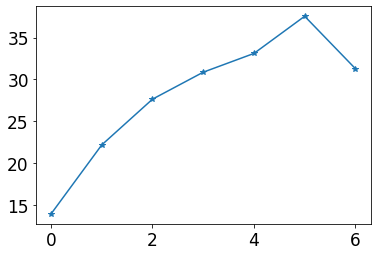

In [1158]:
plt.plot(center_list[2]['test_acc_tracker'], '*-')

In [1159]:
def plot_all_hist(state_dict, ax, title, iflog=True):
    big_tensor = []
    for key in state_dict.keys():
        big_tensor.append(state_dict[key].flatten())
    big_tensor = torch.cat(big_tensor)

    # sns.distplot(np.log(abs(big_tensor.cpu().numpy())+1e-12), ax=ax)
    if iflog:
        ax.hist(np.log10(abs(big_tensor.cpu().numpy())+1e-8), bins=100)
    else:
        ax.hist(big_tensor.cpu().numpy(), bins=100)
        
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.set_title(title)
    # ax.set_xlabel('log(F_i)')
    print('Name: %s, Max: %f, Min: %f' % (title, 
                                          abs(big_tensor.cpu().numpy()).max(),
                                          abs(big_tensor.cpu().numpy()).min()))

(0.0, 0.6)

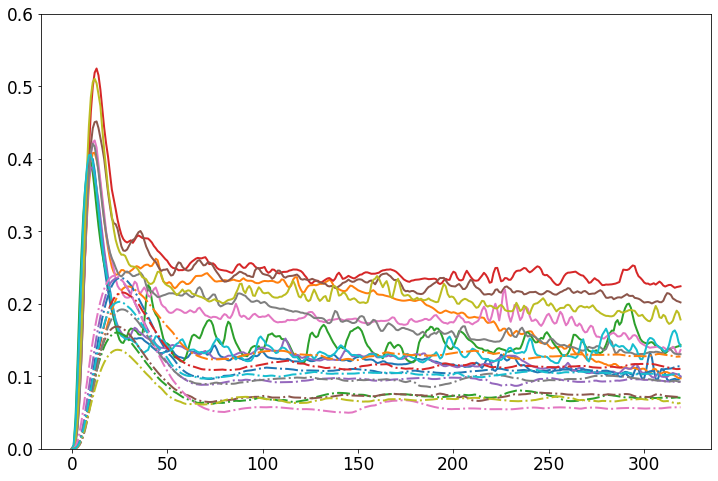

In [1166]:
plt.figure(figsize=[12,8])
for i in range(10, 30):
    if i in list(range(10, 20)):
        ls = '-'
    elif i in list(range(20, 30)):
        ls = '-.'
    else:
        ls = '--'
    plt.plot(round_devices[i]['train_fisher_loss_tracker'], label=str(i), linewidth=2, linestyle=ls)
    
plt.ylim([0,0.6])
# plt.legend()

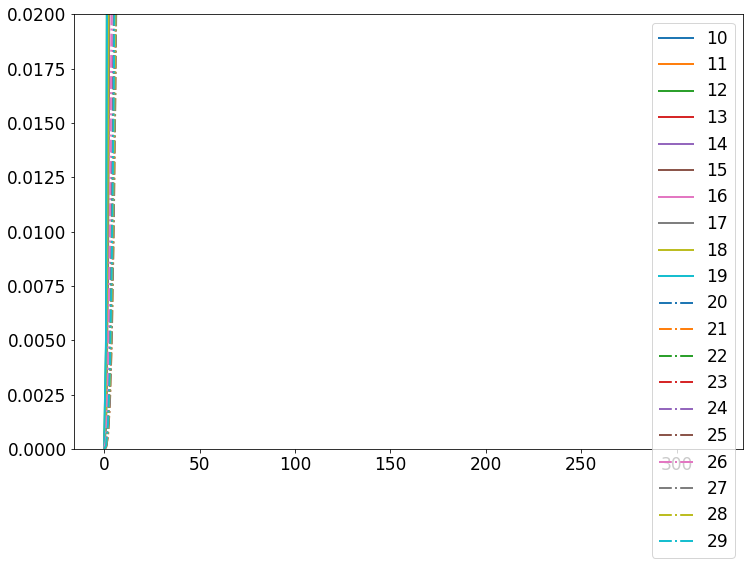

In [1161]:
plt.figure(figsize=[12,8])
for i in range(10, 30):
    if i in list(range(10, 20)):
        ls = '-'
    elif i in list(range(20, 30)):
        ls = '-.'
    else:
        ls = '--'
    plt.plot(round_devices[i]['train_fisher_loss_tracker'], label=str(i), linewidth=2, linestyle=ls)
    
plt.ylim([0,0.02])
plt.legend()

Name: 0, Max: 16.897678, Min: 0.000000
Name: 1, Max: 16.897678, Min: 0.000000
Name: 2, Max: 16.897678, Min: 0.000000
Name: 3, Max: 16.897678, Min: 0.000000
Name: 4, Max: 16.897678, Min: 0.000000
Name: 5, Max: 16.897678, Min: 0.000000


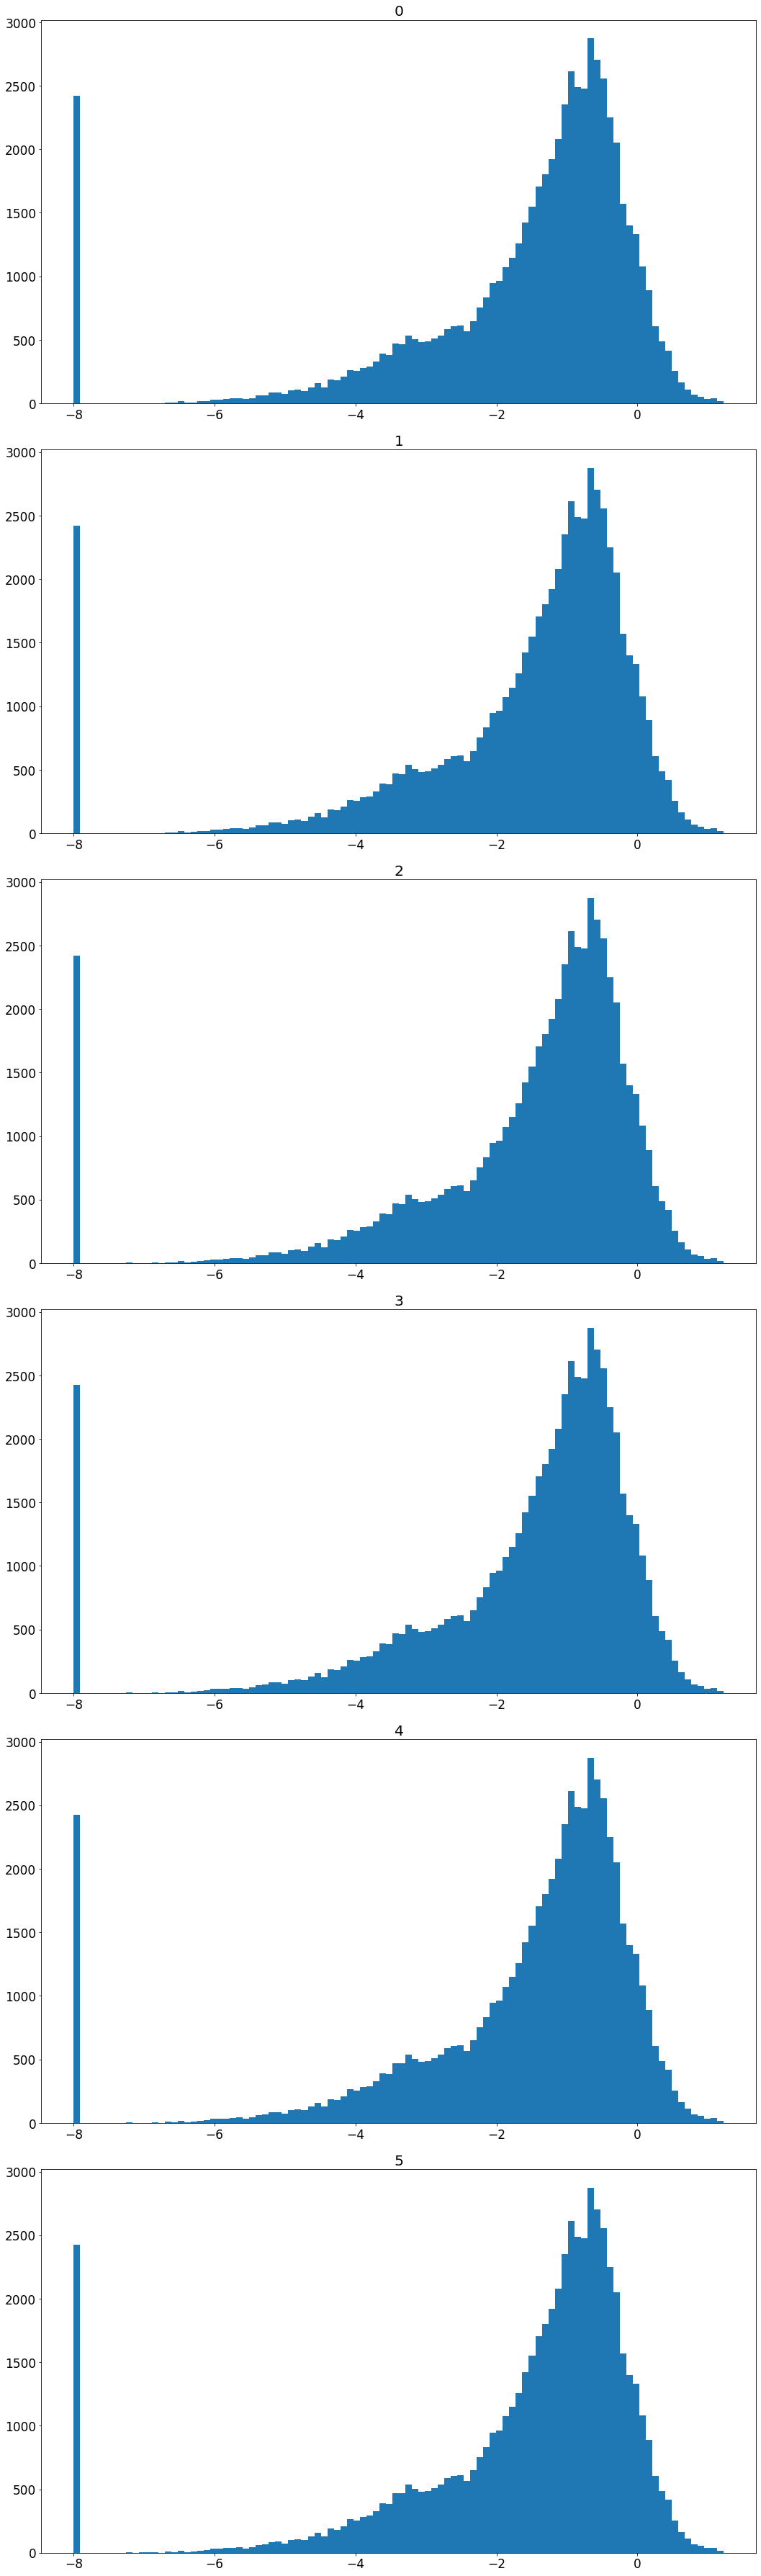

In [1162]:
fig, ax = plt.subplots(len(center_list), 1,  figsize=(15,50), sharex=True)
for i in range(len(center_list)):
    plot_all_hist(center_list[i]['fisher'], ax[i], str(i), True)
plt.tight_layout()

Name: 0, Max: 106.631561, Min: 0.000000
Name: 1, Max: 509.323334, Min: 0.000000
Name: 2, Max: 81.378372, Min: 0.000000
Name: 3, Max: 98.849640, Min: 0.000000
Name: 4, Max: 104.531174, Min: 0.000000
Name: 5, Max: 96.488274, Min: 0.000000
Name: 6, Max: 90.331566, Min: 0.000000
Name: 7, Max: 98.932770, Min: 0.000000
Name: 8, Max: 68.268486, Min: 0.000000
Name: 9, Max: 126.525146, Min: 0.000000
Name: 10, Max: 57.433205, Min: 0.000000
Name: 11, Max: 105.146164, Min: 0.000000
Name: 12, Max: 50.712994, Min: 0.000000
Name: 13, Max: 49.142845, Min: 0.000000
Name: 14, Max: 57.785954, Min: 0.000000
Name: 15, Max: 68.264038, Min: 0.000000
Name: 16, Max: 49.168961, Min: 0.000000
Name: 17, Max: 60.352715, Min: 0.000000
Name: 18, Max: 35.363777, Min: 0.000000
Name: 19, Max: 47.724705, Min: 0.000000
Name: 20, Max: 43.385788, Min: 0.000000
Name: 21, Max: 66.021576, Min: 0.000000
Name: 22, Max: 65.944229, Min: 0.000000
Name: 23, Max: 65.470680, Min: 0.000000
Name: 24, Max: 36.222332, Min: 0.000000
Name:

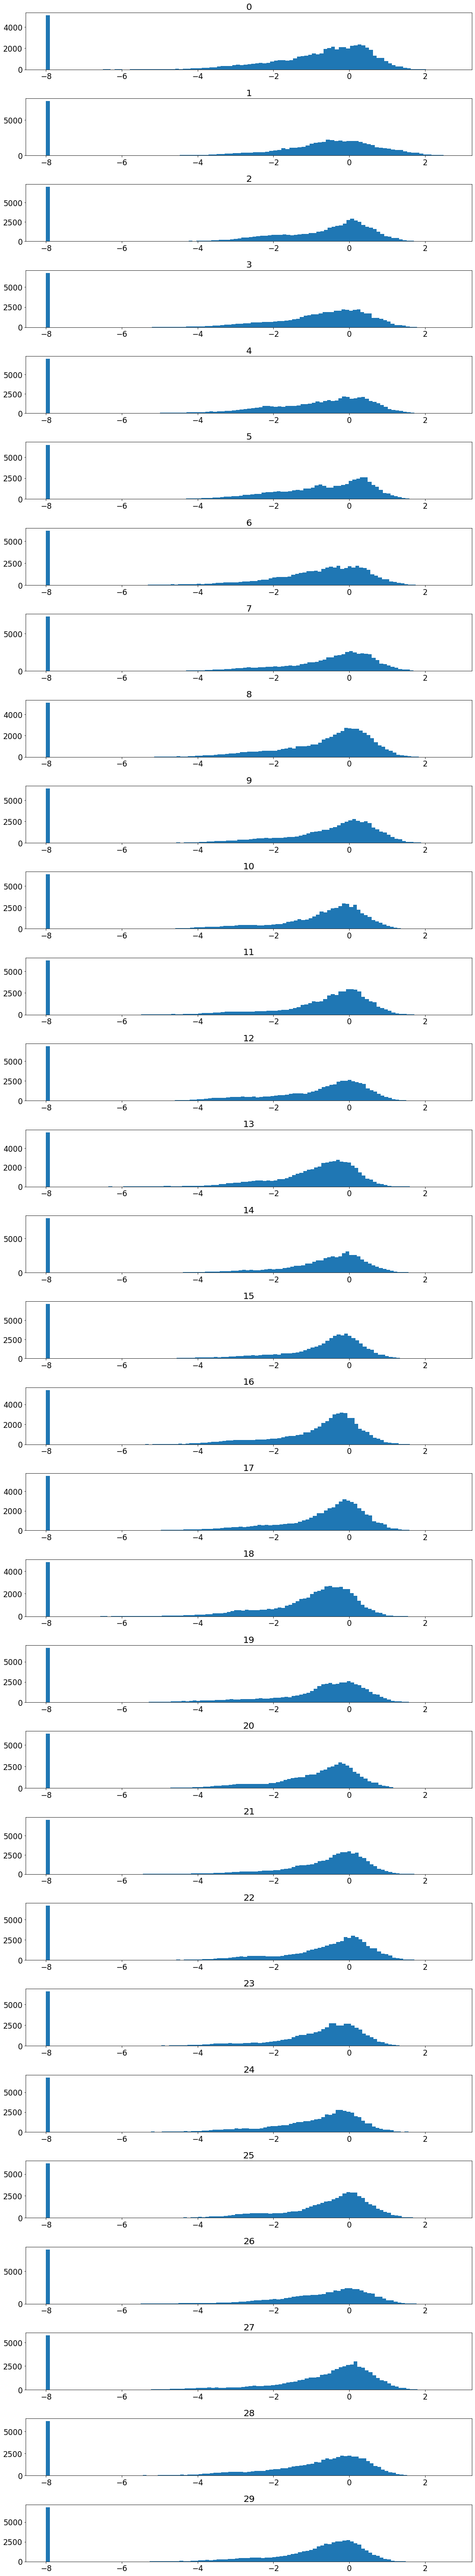

In [1163]:
fig, ax = plt.subplots(len(round_devices), 1,  figsize=(15,80), sharex=True)
for i in range(len(round_devices)):
    plot_all_hist(round_devices[i]['fisher'], ax[i], str(i), True)
plt.tight_layout()

In [1164]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[24,8])
# for i in [6,7,8,9,10,11]:
#     p = ax1.plot(devices[i]['train_acc_tracker'], label='w/ fisher reg' if i <=8 else 'w/o fisher reg', linewidth=3, linestyle='dashed' if i<=8 else 'solid')
#     ax2.plot([devices[i]['test_acc_tracker'][-1]]*len(devices[i]['train_acc_tracker']), label='w/ fisher reg' if i <=8 else 'w/o fisher reg', color=p[0].get_color(), linewidth=3, linestyle='dashed' if i<=8 else 'solid')
    
# ax1.plot([center_device['test_acc_tracker'][-1]]*len(devices[i]['train_acc_tracker']),'v', label='start from')
# ax1.legend()
# ax2.legend()

In [1165]:
# import jovian
# jovian.commit(filename='lab-tworound.ipynb', message='ID:3 version 2')